In [116]:
from convokit import Corpus, download, HyperConvo
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import json
from datetime import datetime
import pickle as pk

In [179]:
from nltk import word_tokenize 
from nltk.util import ngrams
from collections import Counter

In [181]:
import collections.abc
collections.Hashable = collections.abc.Hashable
from numpy_ml import ngram

In [451]:
import scipy.stats as stats

SUBREDDITS = ['Buddhism', 'Christianity', 'TrueChristian', 'Judaism', 'exchristian', 'Catholicism']
MONTHS = [
    '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10',
    '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
    '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
    '2018-07', '2018-08', '2018-09', '2018-10'
]
def calc_conf_interval(data):
    interval = stats.norm.interval(confidence=0.95, loc=np.mean(data), scale=stats.sem(data))
    return (interval[-1] - interval[0])/2

In [256]:
# def preprocess(corpus):
#     for utt in corpus.iter_utterances():
#         datetime_obj = datetime.fromtimestamp(utt.timestamp)
#         utt.add_meta("year", datetime_obj.year)
#         utt.add_meta("month", datetime_obj.month)
#         utt.add_meta("day", datetime_obj.day)
#         utt.add_meta("moreThanFiveWords", len(utt.text.split()) > 5)
#     return corpus

In [258]:
# for subreddit in [
# #     'exchristian', 
# #     'RadicalChristianity', 
#     'Catholicism'
# ]:
#     corpus = Corpus(filename=download(f'subreddit-{subreddit}'), storage_type='db')
#     corpus = preprocess(corpus)
#     df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)
#     df = df[df['speaker'] != "[deleted]"]
#     df['year-month'] = df['meta.year'].astype(str) + "-" + df['meta.month'].astype(str).str.zfill(2)
#     dfs[subreddit] = df

Dataset already exists at /Users/wyw/.convokit/downloads/subreddit-Catholicism


## Prepare dataset

In [11]:
from convokit import Corpus, download, HyperConvo
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import json
from datetime import datetime
import pickle as pk
import matplotlib.pyplot as plt

In [17]:
dfs = dict()
for subreddit in SUBREDDITS:
    corpus = Corpus.reconnect_to_db(f'subreddit-{subreddit}')
    df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)
    df = df[df['speaker'] != "[deleted]"]
    df['year-month'] = df['meta.year'].astype(str) + "-" + df['meta.month'].astype(str).str.zfill(2)
    dfs[subreddit] = df
    

In [560]:
newcomer_ratio = dict()

for subreddit in SUBREDDITS:
    df = dfs[subreddit]
    first_post = df.groupby(['speaker'])['year-month'].min()
    first_post = first_post.reset_index()
    utts_by_year = df.groupby('year-month').size()
    spks_by_year = df.groupby(['year-month'])['speaker'].nunique()
    # number of newcomer in each year
    s = pd.concat([first_post.groupby('year-month').size(), utts_by_year, spks_by_year], axis=1)
    s = s.rename({0: "newcomer", 1: "utterances"}, axis=1)
    s['oldmembers'] = s['speaker'] - s['newcomer']
    s['newcomer / speaker'] = 100 * (s['newcomer'] / s['speaker'])
    s.columns = pd.MultiIndex.from_product([[subreddit], s.columns])
    newcomer_ratio[subreddit] = s

In [60]:
# import pickle as pk
# pk.dump(dfs, open("utts.pk", "wb"))

In [61]:
df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.author_flair_text,meta.gilded,meta.gildings,meta.permalink,meta.retrieved_on,meta.score,meta.stickied,meta.subreddit,meta.top_level_comment,meta.year,meta.month,meta.day,meta.moreThanFiveWords,vectors,year-month
id,,,,,,,,,,,,,,,,,,,,
cl2lw,1278016773,"""We are susceptible to heretical teachings bec...",Tiomaidh,None,cl2lw,Anglican Communion,0,None,/r/Christianity/comments/cl2lw/i_saw_this_quot...,1522932221,14,False,Christianity,None,2010,7,1,True,[],2010-07
cl4fg,1278027744,Let's keep him in our [prayers](http://www.bib...,nopaniers,None,cl4fg,,0,None,/r/Christianity/comments/cl4fg/christopher_hit...,1522932259,9,False,Christianity,None,2010,7,1,True,[],2010-07
clfza,1278105148,http://www.reddit.com/r/reddit.com/comments/cl...,chemistry_teacher,None,clfza,,0,None,/r/Christianity/comments/clfza/for_once_christ...,1522932493,0,False,Christianity,None,2010,7,2,True,[],2010-07
clfze,1278105158,http://www.reddit.com/r/reddit.com/comments/cl...,chemistry_teacher,None,clfze,,0,None,/r/Christianity/comments/clfze/for_once_christ...,1522932493,0,False,Christianity,None,2010,7,2,True,[],2010-07
clg0l,1278105416,http://www.reddit.com/r/reddit.com/comments/cl...,chemistry_teacher,None,clg0l,,0,None,/r/Christianity/comments/clg0l/for_once_christ...,1522932495,0,False,Christianity,None,2010,7,2,True,[],2010-07


In [260]:
comments = dict()
for subreddit in SUBREDDITS:
    df = dfs[subreddit]
    comments[subreddit] = df[df['reply_to'].notnull()].copy()

In [455]:
# pk.dump(comments, open("comments.pk", "wb"))

In [261]:
speaker_comments_stats = dict()
for subreddit in SUBREDDITS:
    speaker_comments_by_month = comments[subreddit].groupby(['speaker', 'year-month']).size().reset_index(name="n_comments_this_month")
    speaker_comments_by_month['cum_comments'] = speaker_comments_by_month.groupby(['speaker'])['n_comments_this_month'].cumsum(axis=0)
    speaker_comments_by_month['n_comments_before_month'] = speaker_comments_by_month['cum_comments'] - speaker_comments_by_month['n_comments_this_month']
    speaker_comments_stats[subreddit] = speaker_comments_by_month

In [287]:
selected_ref_speakers = valid_ref_speakers
selected_spk_comments_df = comments_df[
    (comments_df['speaker'].isin(selected_ref_speakers)) & 
    (comments_df['year-month'] == year_month)
                                      ]
selected_spk_comments_df.groupby('speaker').apply(lambda x: x.sample(2)).reset_index(drop=True)['id']

0       e78jw1u
1       e8q5rxh
2       e83twsw
3       e8kkoaq
4       e7mu4c1
         ...   
1673    e7rseyg
1674    e7pr81m
1675    e8mc5nb
1676    e7jy82f
1677    e8q9nzw
Name: id, Length: 1678, dtype: object

In [294]:
ref_comments_df = selected_spk_comments_df.reset_index().groupby('speaker').apply(
            lambda x: x.sample(n_comments_per_spk)
        )

In [296]:
ref_comments_df.reset_index(drop=True)

,id,speaker,year-month,text
0,cz3shob,-Mochaccina-,2016-01,"Yes, only, on the physical side, because it's ..."
1,czbw38q,-Mochaccina-,2016-01,Every age group is represented at our Parish a...
2,czijxqb,0001u,2016-01,'An influential Italian Catholic leader presen...
3,cz59ic0,0001u,2016-01,Is it really just rumour? Has he not explicitl...
4,cz6ia2r,10113519,2016-01,&gt; It maintains that a foetus is a person wo...
...,...,...,...,...
947,czcp5as,you_know_what_you,2016-01,I hear great things about this Baronius Press ...
948,cz6u421,zero44,2016-01,"I really like the sound of a lot of APC, and i..."
949,cypgbrz,zero44,2016-01,&gt;I also see I need to go to Mass on the Thu...
950,cz792r9,zxo,2016-01,"Yes, this is the section I was thinking of, th..."


In [308]:
speaker_comments_by_month.sort_values("speaker")

,speaker,year-month,n_comments_this_month,cum_comments,n_comments_before_month
0,--3--,2016-05,2,2,0
1,--Francis--,2017-06,1,1,0
2,--RF--,2018-07,3,3,0
3,--RF--,2018-09,1,4,3
4,--Sigma--,2014-04,5,5,0
...,...,...,...,...,...
143266,zyzzvya,2015-09,15,15,0
143267,zzing,2010-11,3,3,0
143268,zzing,2013-09,4,7,3
143269,zzzbleble,2016-08,3,3,0


In [346]:
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 80)
).to_dict()

{'2012-05': 0.0,
 '2012-06': 0.0,
 '2012-07': 0.0,
 '2012-08': 1.0,
 '2012-09': 1.8000000000000114,
 '2012-10': 45.00000000000003,
 '2012-11': 39.60000000000001,
 '2012-12': 28.400000000000006,
 '2013-01': 43.2,
 '2013-02': 36.0,
 '2013-03': 19.600000000000023,
 '2013-04': 37.0,
 '2013-05': 46.0,
 '2013-06': 8.0,
 '2013-07': 11.0,
 '2013-08': 13.0,
 '2013-09': 28.0,
 '2013-10': 77.60000000000014,
 '2013-11': 35.400000000000034,
 '2013-12': 39.0,
 '2014-01': 43.0,
 '2014-02': 58.400000000000034,
 '2014-03': 45.0,
 '2014-04': 44.80000000000007,
 '2014-05': 49.60000000000002,
 '2014-06': 55.0,
 '2014-07': 49.60000000000002,
 '2014-08': 53.2000000000001,
 '2014-09': 63.0,
 '2014-10': 40.60000000000002,
 '2014-11': 44.0,
 '2014-12': 43.0,
 '2015-01': 37.0,
 '2015-02': 41.0,
 '2015-03': 38.0,
 '2015-04': 45.0,
 '2015-05': 40.40000000000009,
 '2015-06': 46.200000000000045,
 '2015-07': 52.0,
 '2015-08': 62.200000000000045,
 '2015-09': 63.200000000000045,
 '2015-10': 62.80000000000007,
 '2015-1

<AxesSubplot: xlabel='year-month'>

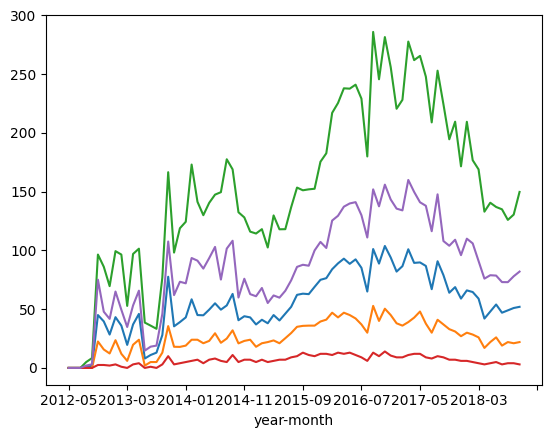

In [339]:
subreddit = 'TrueChristian'
speaker_comments_by_month = speaker_comments_stats[subreddit]
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 80)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 70)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 90)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 50)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 85)
).plot()

In [311]:
speaker_comments_by_month[speaker_comments_by_month['speaker'] == 'avengingturnip']

,speaker,year-month,n_comments_this_month,cum_comments,n_comments_before_month
76199,avengingturnip,2009-02,1,1,0
76200,avengingturnip,2010-03,3,4,1
76201,avengingturnip,2010-04,3,7,4
76202,avengingturnip,2010-09,15,22,7
76203,avengingturnip,2010-10,9,31,22
...,...,...,...,...,...
76288,avengingturnip,2018-06,32,5766,5734
76289,avengingturnip,2018-07,50,5816,5766
76290,avengingturnip,2018-08,119,5935,5816
76291,avengingturnip,2018-09,39,5974,5935


### select reference comments

In [352]:
# for every month after 2016
# ref_comments_idx = dict()
# ref_comments_text = dict()

n_comments_per_spk = 2

for subreddit in [
#     'TrueChristian', 
#     'Buddhism', 
#     'Judaism',
    'Christianity',
#     'exchristian', 
    'RadicalChristianity', 
#     'Catholicism'
]:
    print(subreddit)
    ref_comments_idx[subreddit] = dict()
    ref_comments_text[subreddit] = dict()
    comments_df = comments[subreddit][['speaker', 'year-month', 'text']]
    speaker_comments_by_month = speaker_comments_stats[subreddit]
    activity_index = speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 80)
    ).to_dict()
    for year_month in MONTHS:
        print(' ', year_month)
        ref_comments_idx[subreddit][year_month] = list()
        ref_comments_text[subreddit][year_month] = list()
        
        valid_ref_speakers = speaker_comments_by_month[
        (speaker_comments_by_month['year-month'] == year_month) &
        (speaker_comments_by_month['n_comments_before_month'] >= activity_index[year_month]) &
        (speaker_comments_by_month['n_comments_this_month'] >= 5) 
                             ]['speaker'].unique()

#         selected_ref_speakers = np.random.choice(valid_ref_speakers, size=n_spk, replace=False)
        selected_ref_speakers = valid_ref_speakers
        selected_spk_comments_df = comments_df[
            (comments_df['speaker'].isin(selected_ref_speakers)) & 
            (comments_df['year-month'] == year_month)
                                              ].reset_index()
        ref_comments_df = selected_spk_comments_df.groupby('speaker').apply(
            lambda x: x.sample(n_comments_per_spk)
        ).reset_index(drop=True)
        ref_comments_idx[subreddit][year_month] += ref_comments_df['id'].values.tolist()
        ref_comments_text[subreddit][year_month] += ref_comments_df['text'].values.tolist()

Christianity
  2016-01
  2016-02
  2016-03
  2016-04
  2016-05
  2016-06
  2016-07
  2016-08
  2016-09
  2016-10
  2016-11
  2016-12
  2017-01
  2017-02
  2017-03
  2017-04
  2017-05
  2017-06
  2017-07
  2017-08
  2017-09
  2017-10
  2017-11
  2017-12
  2018-01
  2018-02
  2018-03
  2018-04
  2018-05
  2018-06
  2018-07
  2018-08
  2018-09
  2018-10
RadicalChristianity
  2016-01
  2016-02
  2016-03
  2016-04
  2016-05
  2016-06
  2016-07
  2016-08
  2016-09
  2016-10
  2016-11
  2016-12
  2017-01
  2017-02
  2017-03
  2017-04
  2017-05
  2017-06
  2017-07
  2017-08
  2017-09
  2017-10
  2017-11
  2017-12
  2018-01
  2018-02
  2018-03
  2018-04
  2018-05
  2018-06
  2018-07
  2018-08
  2018-09
  2018-10


## select community and newcomer comments

In [517]:
from numpy_ml.preprocessing.nlp import tokenize_words, ngrams, strip_punctuation
N=2 # bi-gram
community_tokenized_comments = dict()
newcomer_tokenized_comments = dict()

for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
    'exchristian', 
    'RadicalChristianity', 
    'Catholicism'
]:
    print(subreddit)
    comments_df = comments[subreddit][['speaker', 'year-month', 'text']].reset_index()
    speaker_comments_by_month = speaker_comments_stats[subreddit]

    community_tokenized_comments[subreddit] = dict()
    newcomer_tokenized_comments[subreddit] = dict()
    
    for year_month in MONTHS:
        print(year_month)

        community_tokenized_comments[subreddit][year_month] = list()
        newcomer_tokenized_comments[subreddit][year_month] = list()
        
        new_speakers = speaker_comments_by_month[
        (speaker_comments_by_month['year-month'] == year_month) & 
        (speaker_comments_by_month['n_comments_before_month'] == 0)
                             ]['speaker'].values.tolist()

        month_comments = comments_df[
            (comments_df['year-month'] == year_month) & 
            (~comments_df['id'].isin(ref_comments_idx[subreddit][year_month]))
                                    ].copy()

        newcomer_comments = month_comments[
            (month_comments['speaker'].isin(new_speakers))                                   
        ].reset_index(drop=True).groupby("speaker").apply(lambda x: x.sample(1)).reset_index(drop=True).to_dict(orient='records')
        
        community_comments = month_comments[
            (~month_comments['speaker'].isin(new_speakers))                                   
        ].reset_index(drop=True).groupby("speaker").apply(lambda x: x.sample(1)).reset_index(drop=True).to_dict(orient='records')
            
        for utt in community_comments:

            line = strip_punctuation(utt['text'])
            words = tokenize_words(line, filter_stopwords=False)
            community_tokenized_comments[subreddit][year_month].append(words)

        for utt in newcomer_comments:

            line = strip_punctuation(utt['text'])
            words = tokenize_words(line, filter_stopwords=False)
            newcomer_tokenized_comments[subreddit][year_month].append(words)


TrueChristian
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
Buddhism
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
Judaism
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
Christianity
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017

/var/folders/dv/nftpj5h959v6gdnphbshtdzr0000gn/T/ipykernel_20530/254440272.py:40: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ].reset_index(drop=True).groupby("speaker").apply(lambda x: x.sample(1)).reset_index(drop=True).to_dict(orient='records')


2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
Catholicism
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10


In [539]:
[' '.join(tokens) for tokens in community_tokenized_comments['Catholicism']['2017-07']]

['wonder if you would feel that way if it was your child the american doctor said conservative estimate for charlies recovery through the surgery was 10 thats not medical experiment but last resort treatment and the parents are right to have chosen that path',
 'think your comment hits the closest to home especially with the marriage bit nice touch my background is definitely one filled with showy emotional christian people im sure that taints me some but do recognize that its not about feelings or emotion thats one thing that immediately drew me to the catholic church there is verifiable history and plethora of rational reasons why this is the church jesus founded it didnt have to feel good as it was demonstrably true truth is all have ever cared about and sometimes focus on doing it the right way too much im sure with all that in mind will concede that sense of the lack of god does in fact influence my thoughts',
 'in my diocese we have the shrine of the most holy redeemer and all th

In [518]:
from numpy_ml.preprocessing.nlp import tokenize_words, ngrams, strip_punctuation
N=2 # bi-gram
community_cross_entropy = dict()
newcomer_cross_entropy = dict()
ref_cross_entropy = dict() # sanity check
for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
    'exchristian', 
    'RadicalChristianity', 
    'Catholicism'
]:
    print(subreddit)
    comments_df = comments[subreddit][['speaker', 'year-month', 'text']].reset_index()
    speaker_comments_by_month = speaker_comments_stats[subreddit]

    community_cross_entropy[subreddit] = dict()
    newcomer_cross_entropy[subreddit] = dict()
    ref_cross_entropy[subreddit] = dict()
    
    for year_month in MONTHS:
        print(year_month)

        community_cross_entropy[subreddit][year_month] = list()
        newcomer_cross_entropy[subreddit][year_month] = list()
        ref_cross_entropy[subreddit][year_month] = list()
        ref_filename = f'./ref-{subreddit}-{year_month}.txt'
#         with open(ref_filename, mode='wt', encoding='utf-8') as myfile:
#             myfile.write('\n'.join(utt.replace("\n", " ") for utt in ref_comments_text[subreddit][year_month]))

        gt = ngram.GoodTuringNGram(N, conf=1.96, unk=True, filter_stopwords=False, filter_punctuation=True)
        gt.train(ref_filename)

        
        for utt_text in ref_comments_text[subreddit][year_month]:
            line = strip_punctuation(utt_text)
            words = tokenize_words(utt_text, filter_stopwords=False)
            
            try:
                cross_entropy = gt.cross_entropy(words, N = N)
            except:
                print('skip: ', utt_text, words)
            ref_cross_entropy[subreddit][year_month].append(cross_entropy)
            
        for tokens in community_tokenized_comments[subreddit][year_month]:
            tokens = tokens[:30]
            try:
                cross_entropy = gt.cross_entropy(tokens, N = N)
            except:
                print('skip: ', tokens)
            community_cross_entropy[subreddit][year_month].append(cross_entropy)

        for tokens in newcomer_tokenized_comments[subreddit][year_month]:
            tokens = tokens[:30]
            try:
                cross_entropy = gt.cross_entropy(tokens, N = N)
            except:
                print('skip: ', tokens)
            newcomer_cross_entropy[subreddit][year_month].append(cross_entropy)


TrueChristian
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
skip:  []
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
skip:  []
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
skip:  []
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
skip:  []
2018-05
2018-06
2018-07
2018-08
2018-09
skip:  \ ( ^ ________ ^ ) / ['________']
2018-10
Buddhism
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
Judaism
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
skip:  []
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
skip:  []
2018-10
Christianity
2016-01
2016-02
2016-03
skip:  []
2016-

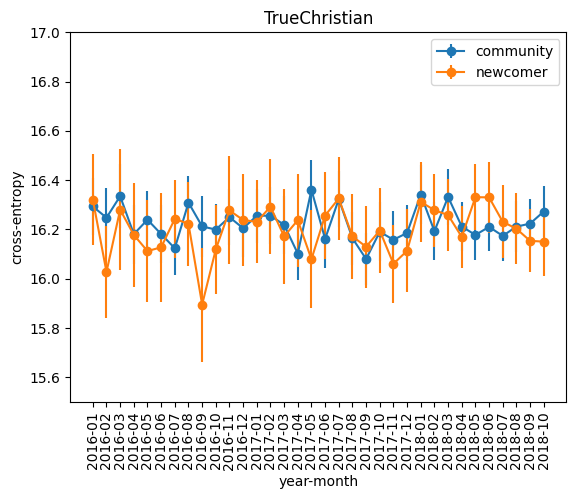

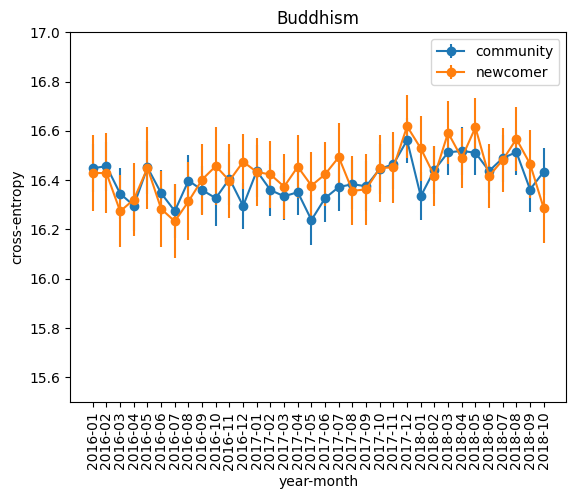

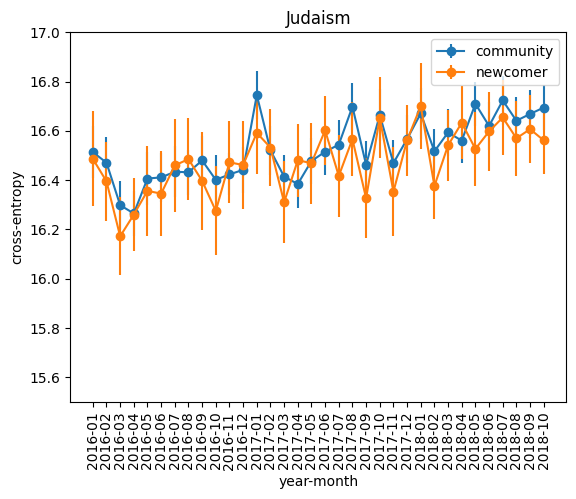

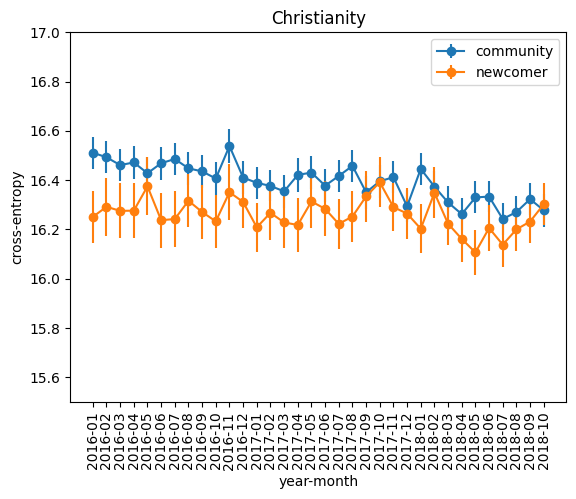

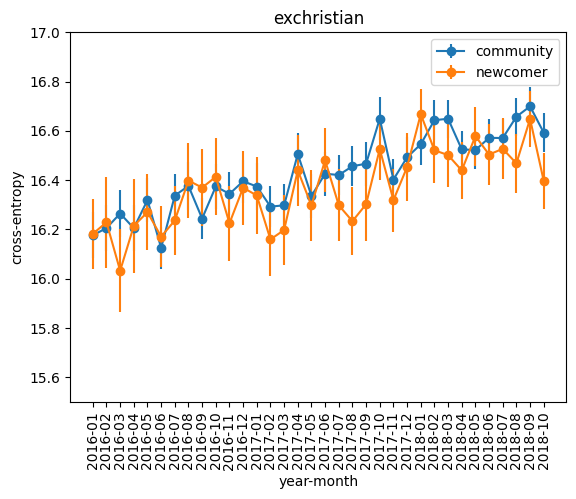

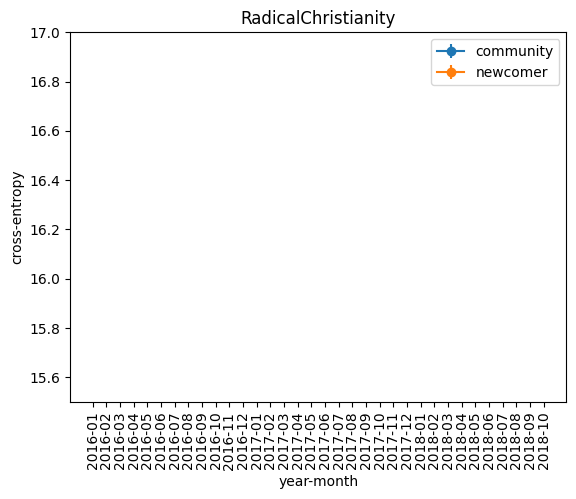

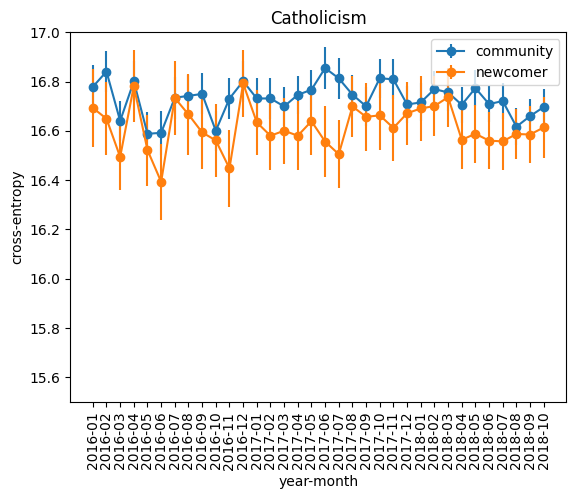

In [523]:
for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
    'exchristian', 
    'RadicalChristianity', 
    'Catholicism'
]:
#     mean = [np.mean(ref_cross_entropy[subreddit][month]) for month in MONTHS]
#     conf_interval = [calc_conf_interval(ref_cross_entropy[subreddit][month]) for month in MONTHS]

#     plt.errorbar(MONTHS, mean, yerr=conf_interval, fmt="o-", label='reference')
    mean = [np.mean(community_cross_entropy[subreddit][month]) for month in MONTHS]
    conf_interval = [calc_conf_interval(community_cross_entropy[subreddit][month]) for month in MONTHS]

    plt.errorbar(MONTHS, mean, yerr=conf_interval, fmt="o-", label='community')

    mean = [np.mean(newcomer_cross_entropy[subreddit][month]) for month in MONTHS]
    conf_interval = [calc_conf_interval(newcomer_cross_entropy[subreddit][month]) for month in MONTHS]

    plt.errorbar(MONTHS, mean, yerr=conf_interval, fmt="o-", label='newcomer')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(subreddit)
    plt.xlabel("year-month")
    plt.ylabel("cross-entropy")
    plt.ylim([15.5, 17])
    plt.savefig(f'cross-entropy-{subreddit}.jpg')
    plt.show()

## Speaker Longitudinal Changes

### Length of comments

Buddhism
Christianity
TrueChristian
Judaism
exchristian
Catholicism


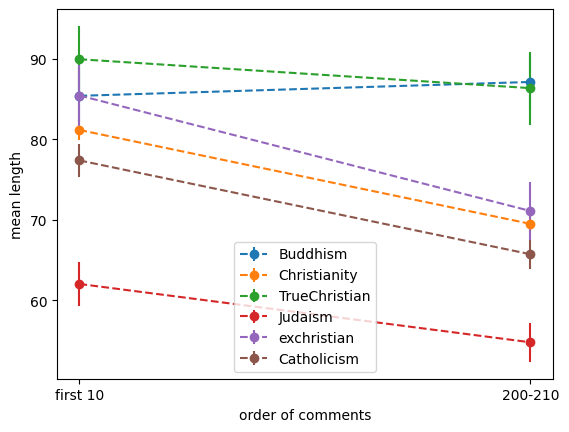

In [648]:
for subreddit in SUBREDDITS:
    print(subreddit)
    df = comments[subreddit]
    group = df.sort_values(['speaker', 'timestamp']).groupby(["speaker"])
    df['order'] = group.cumcount() + 1
    df['text_len'] = df['text'].apply(lambda utt: len(utt.split()))
    speaker_total_comments = df.groupby("speaker")['order'].max().reset_index(name="n_comments")
    speakers = speaker_total_comments[speaker_total_comments['n_comments'] >= 210]['speaker'].values
    # 0 - 10
    early = df[(df['speaker'].isin(speakers)) & (df['order'] <= 10)]

    # 200 - 210
    late = df[(df['speaker'].isin(speakers)) & (df['order'] < 210) & (df['order'] >= 200)]

    plt.errorbar(
        ['first 10', '200-210'], 
        [
            early['text_len'].mean(),
            late['text_len'].mean()
        ],     
        yerr = [
            calc_conf_interval(early['text_len'].values), 
            calc_conf_interval(late['text_len'].values)
        ],
            fmt="o--",
            label=subreddit)
    
plt.legend()
plt.ylabel("mean length")
plt.xlabel("order of comments")
plt.show()


Catholicism


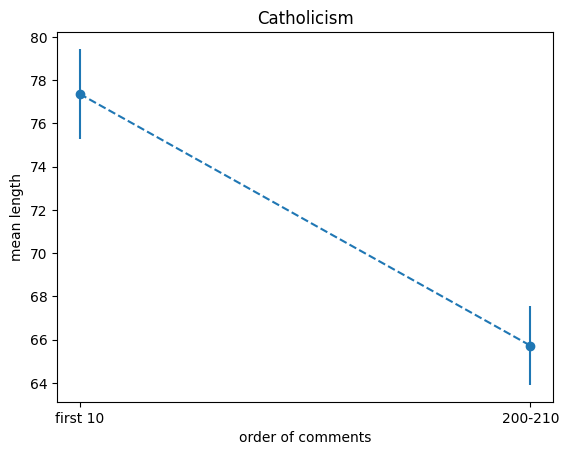

Christianity


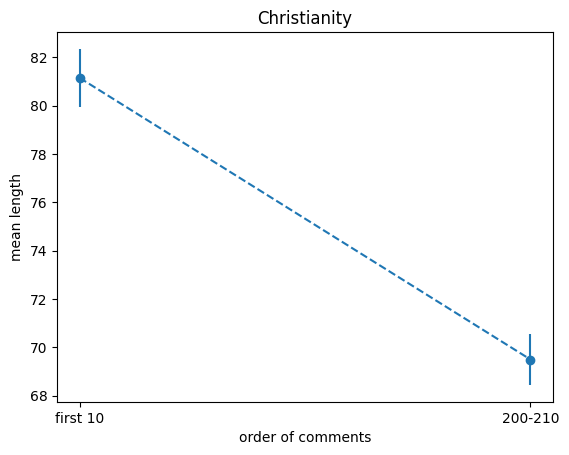

exchristian


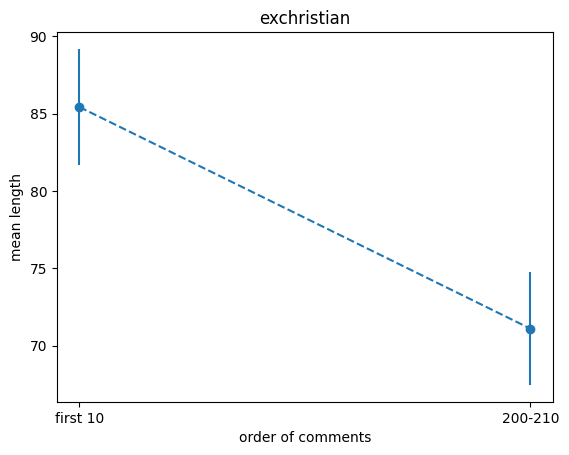

Judaism


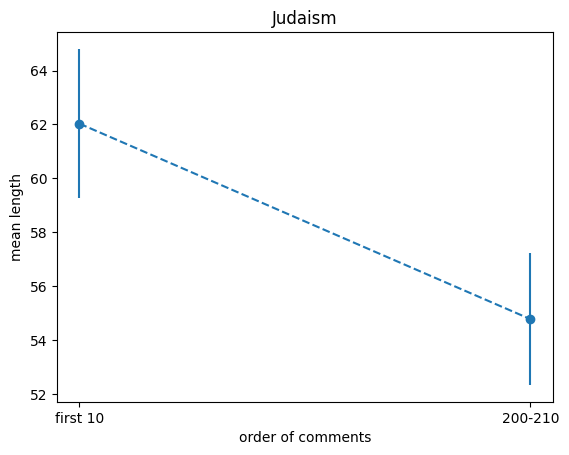

In [649]:
for subreddit in ["Catholicism", "Christianity", "exchristian", 'Judaism',]:
    print(subreddit)
    df = comments[subreddit]
    group = df.sort_values(['speaker', 'timestamp']).groupby(["speaker"])
    df['order'] = group.cumcount() + 1
    df['text_len'] = df['text'].apply(lambda utt: len(utt.split()))
    speaker_total_comments = df.groupby("speaker")['order'].max().reset_index(name="n_comments")
    speakers = speaker_total_comments[speaker_total_comments['n_comments'] >= 210]['speaker'].values
    # 0 - 10
    early = df[(df['speaker'].isin(speakers)) & (df['order'] <= 10)]

    # 200 - 210
    late = df[(df['speaker'].isin(speakers)) & (df['order'] < 210) & (df['order'] >= 200)]

    plt.errorbar(
        ['first 10', '200-210'], 
        [
            early['text_len'].mean(),
            late['text_len'].mean()
        ],     
        yerr = [
            calc_conf_interval(early['text_len'].values), 
            calc_conf_interval(late['text_len'].values)
        ],
            fmt="o--",)
    plt.title(subreddit)
    plt.ylabel("mean length")
    plt.xlabel("order of comments")
    plt.show()


### FightingWords

Buddhism
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 4650 valid corpus components. class2_func returned 4650 valid corpus components.
Vocab size is 4357
Comparing language...
ngram zscores computed.


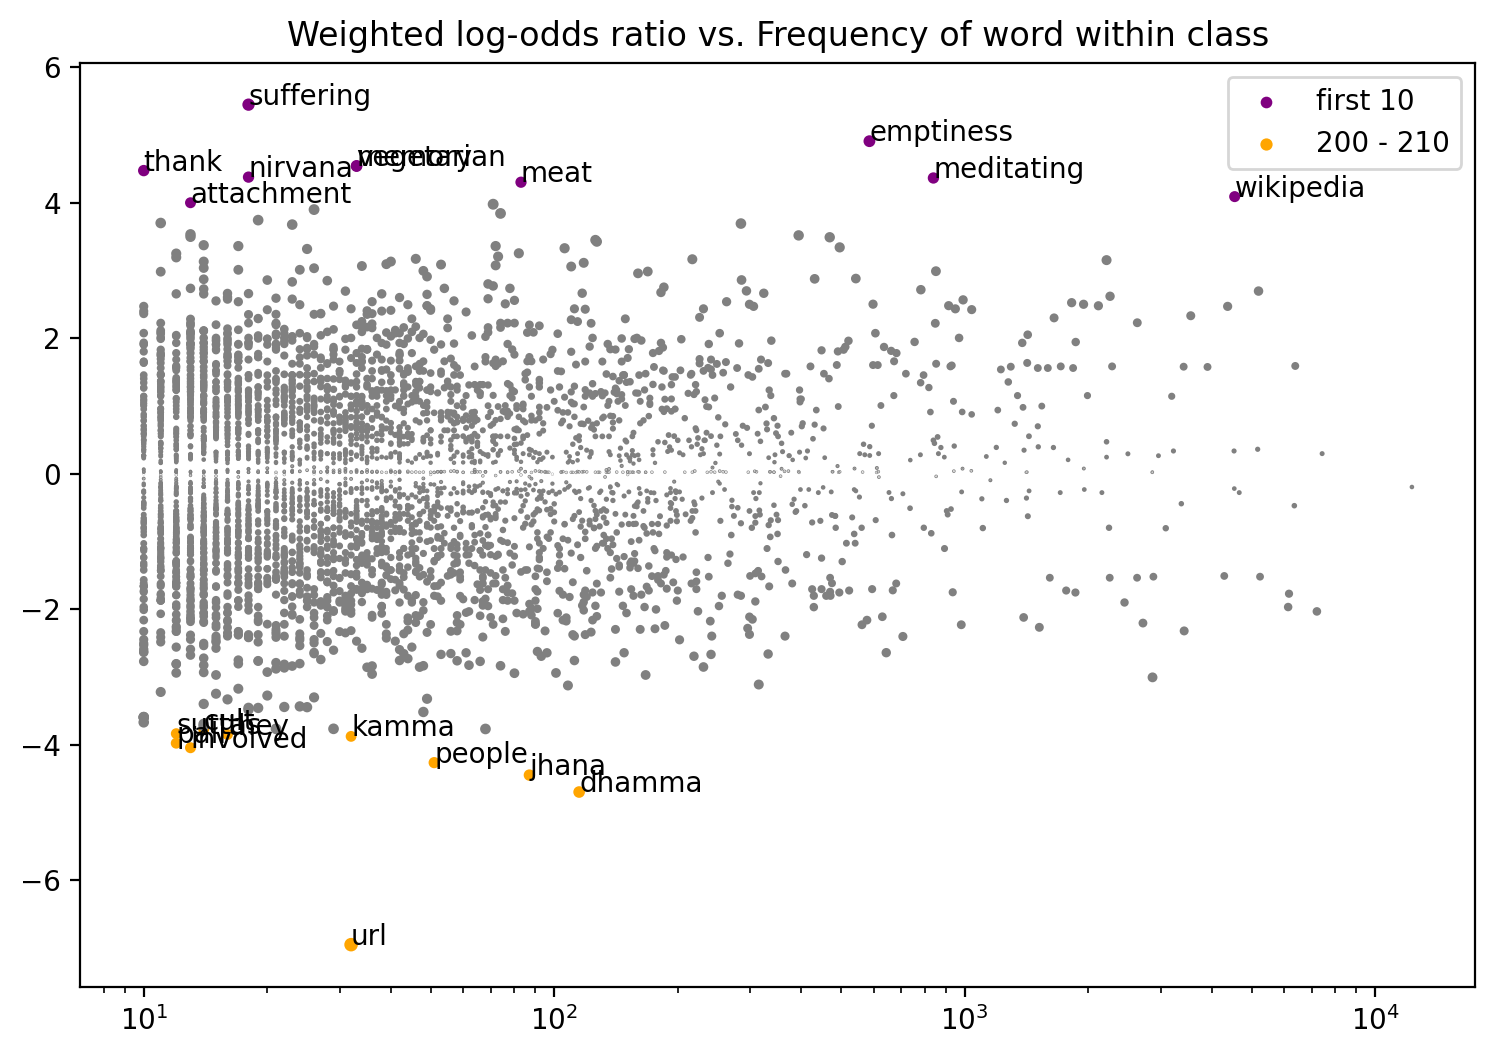

Christianity
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 36470 valid corpus components. class2_func returned 36470 valid corpus components.
Vocab size is 13162
Comparing language...
ngram zscores computed.


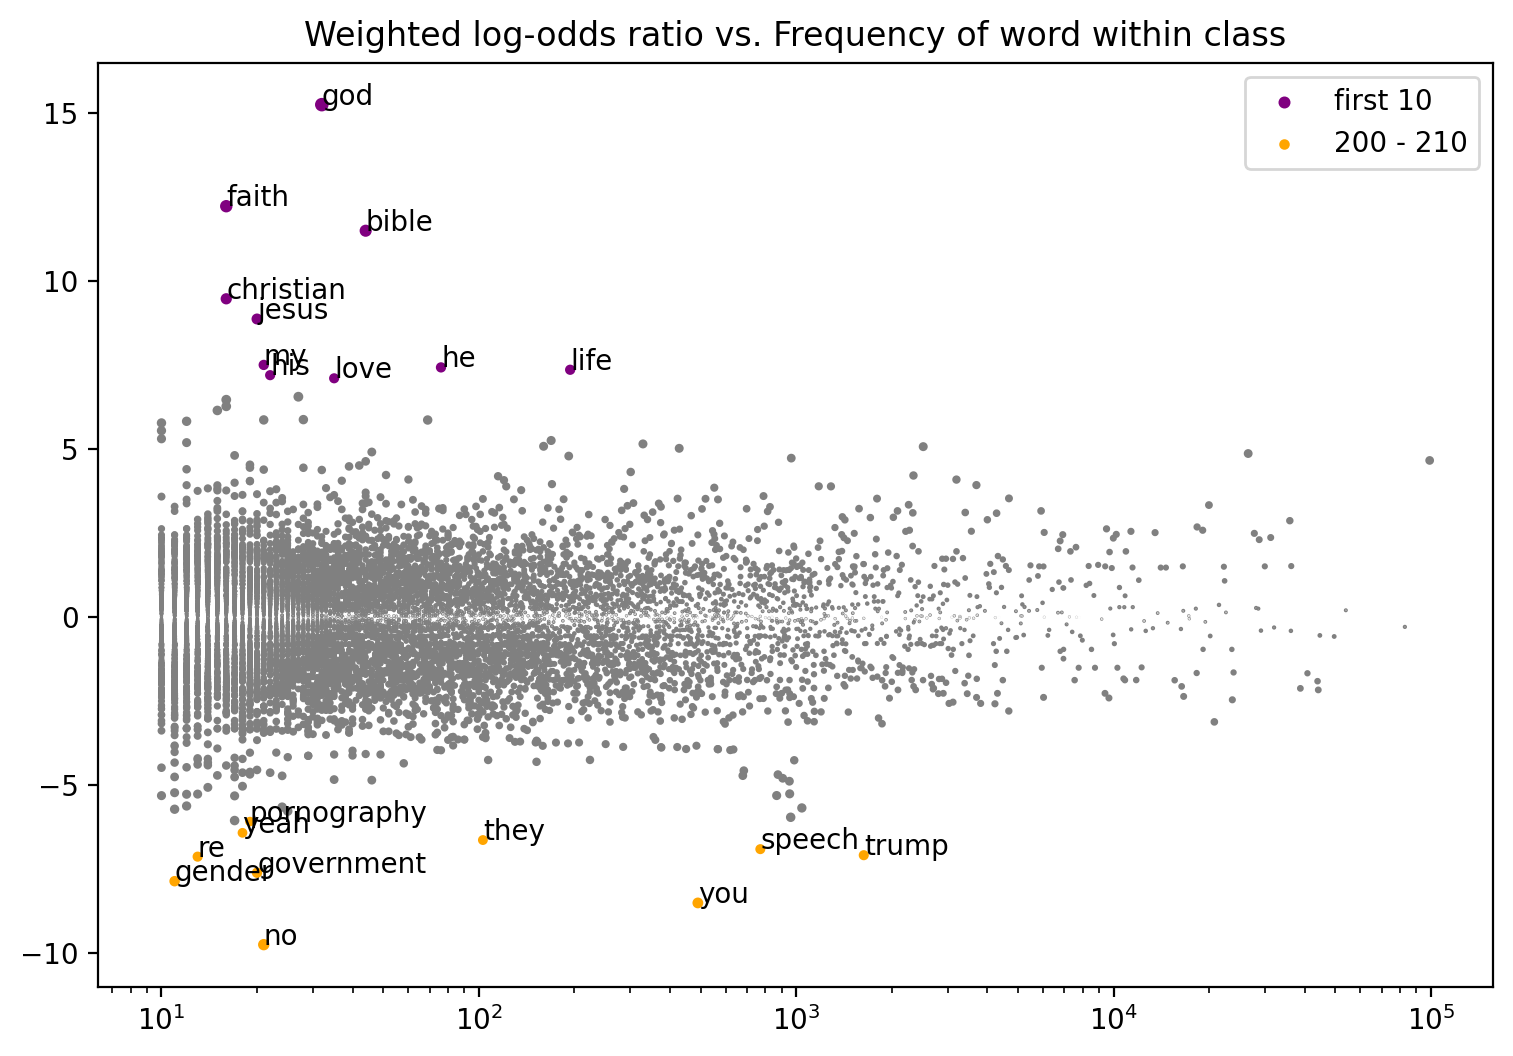

TrueChristian
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 3630 valid corpus components. class2_func returned 3630 valid corpus components.
Vocab size is 3634
Comparing language...
ngram zscores computed.


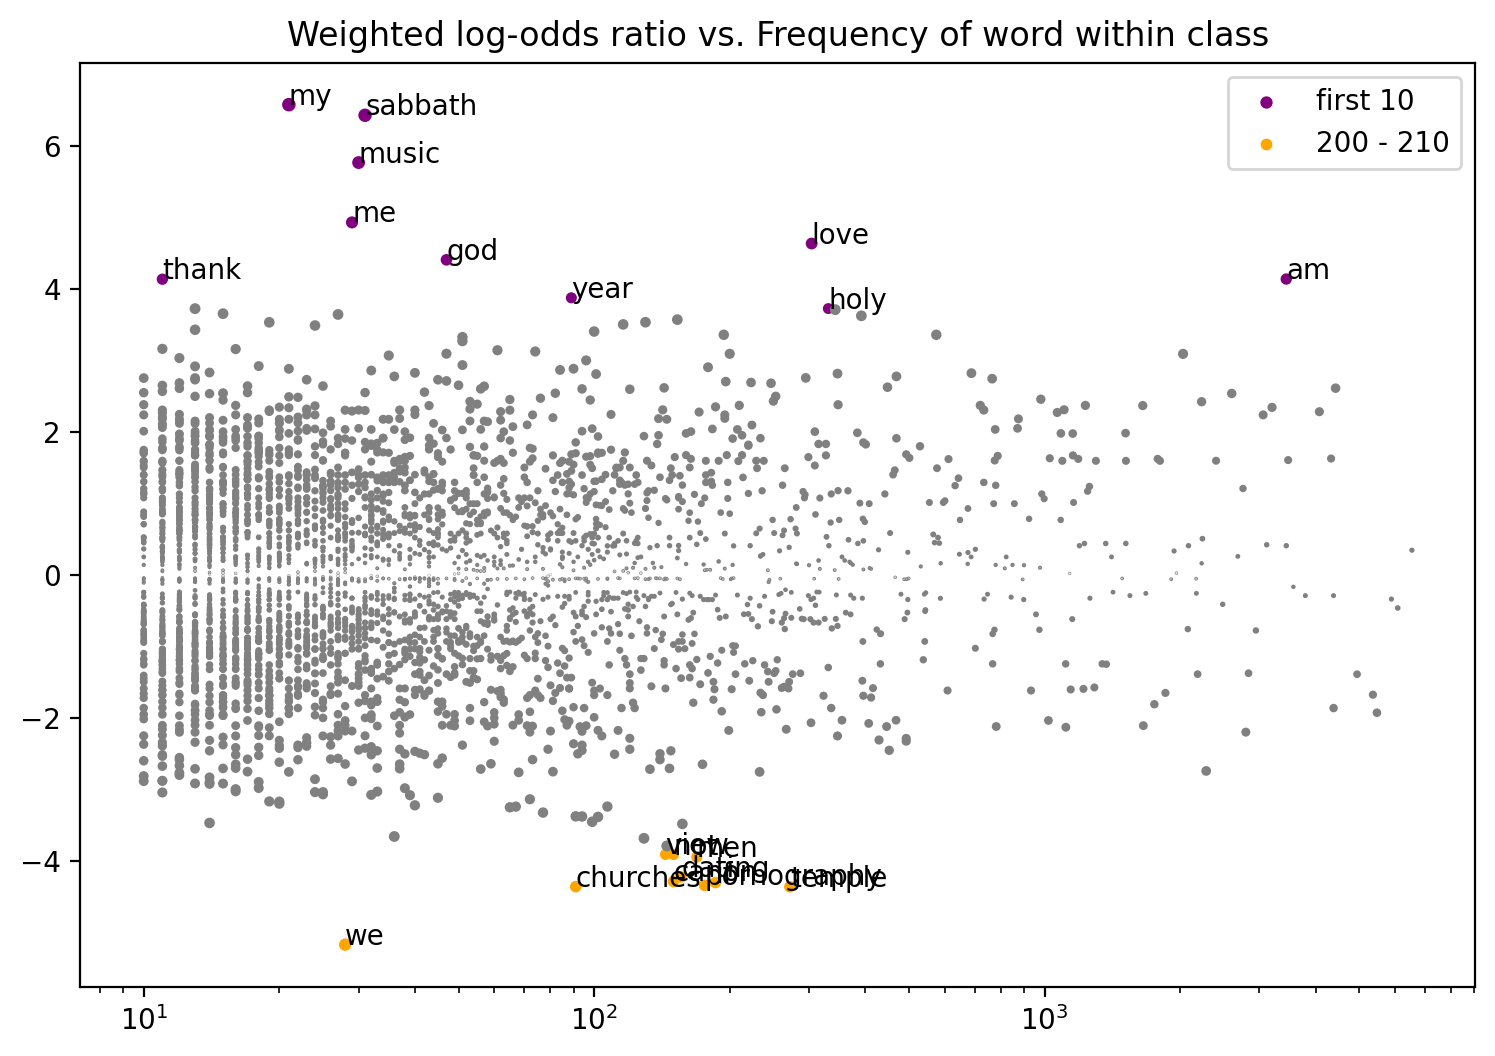

Judaism
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 3870 valid corpus components. class2_func returned 3870 valid corpus components.
Vocab size is 3192
Comparing language...
ngram zscores computed.


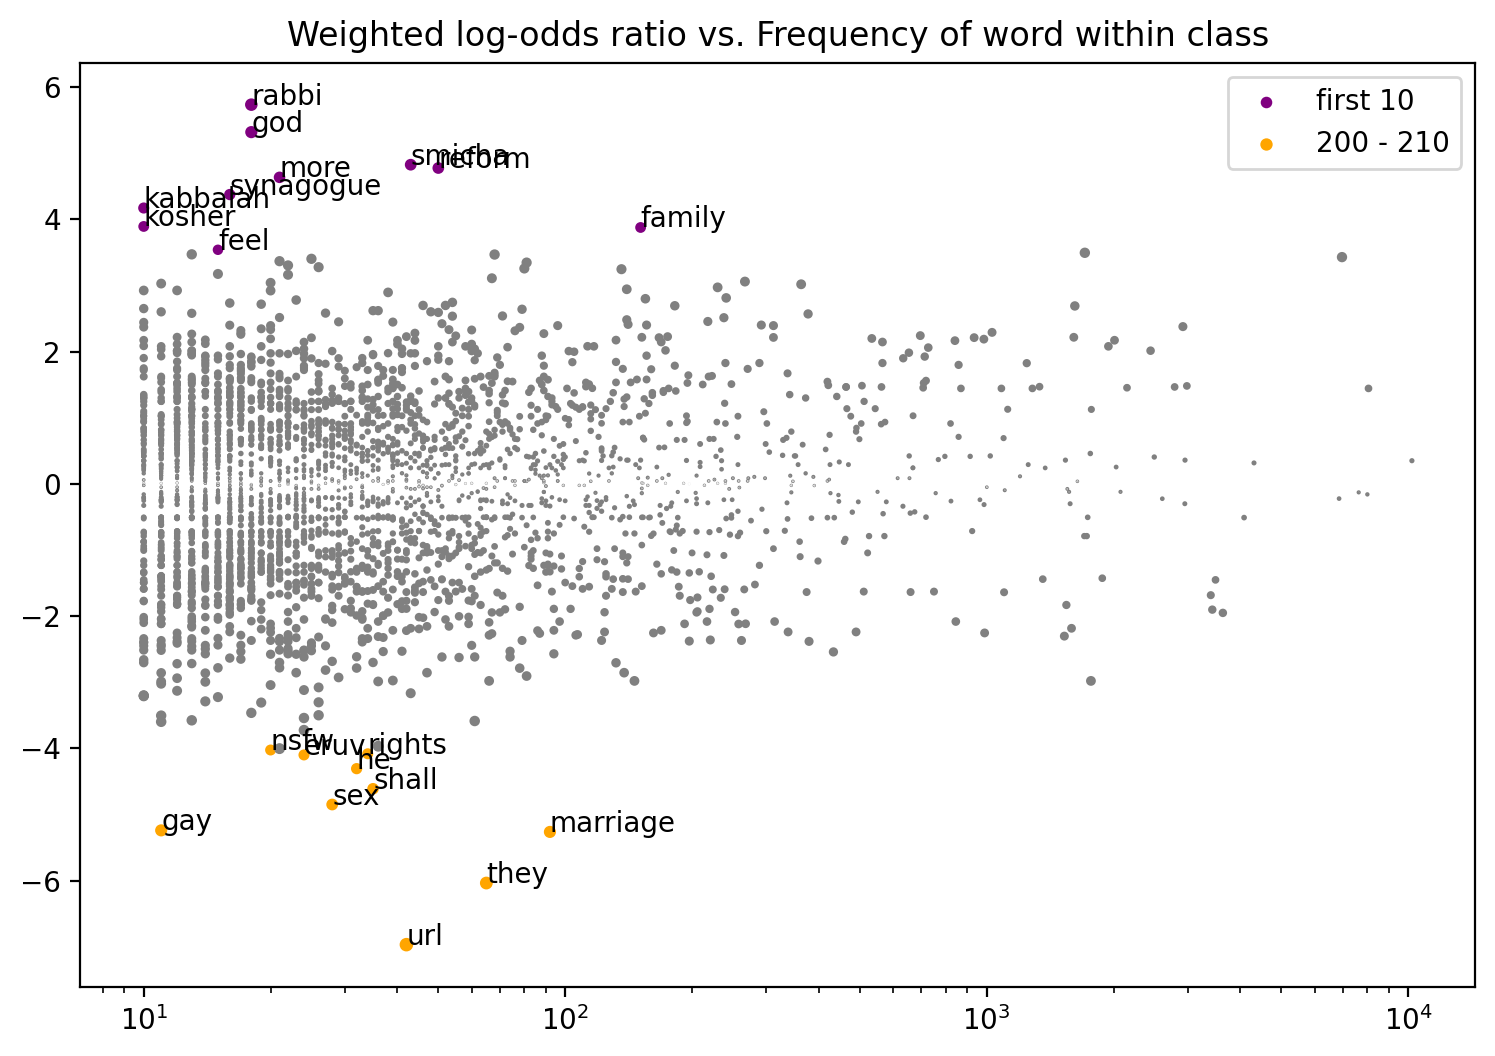

exchristian
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 3110 valid corpus components. class2_func returned 3110 valid corpus components.
Vocab size is 3129
Comparing language...
ngram zscores computed.


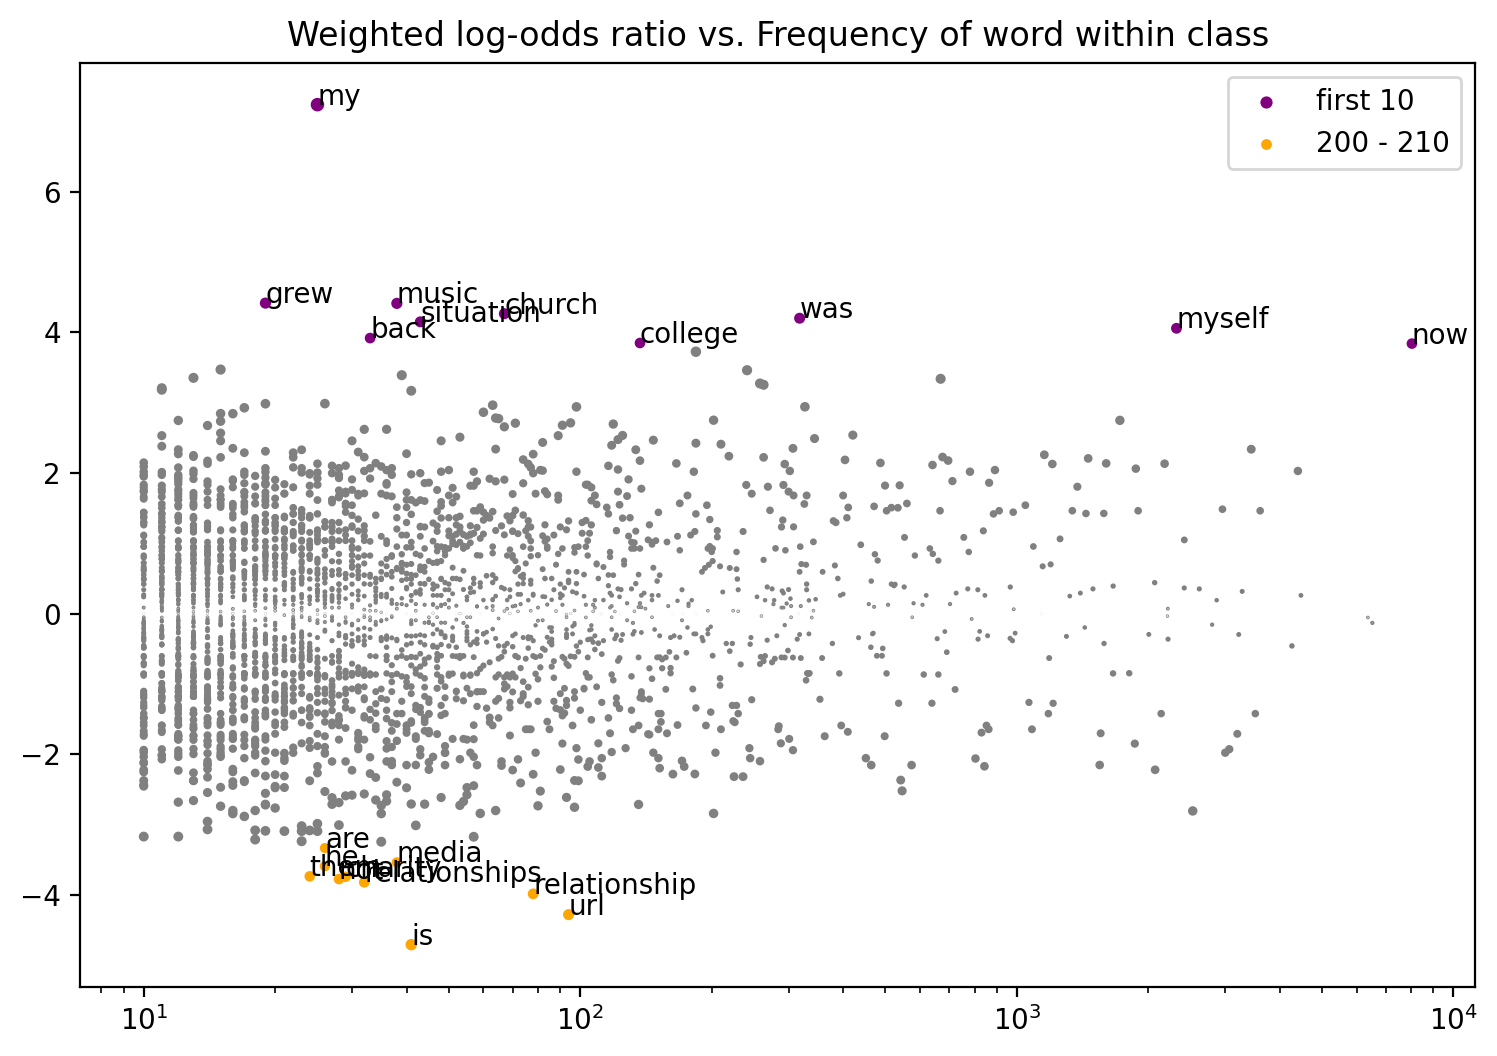

Catholicism
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 11420 valid corpus components. class2_func returned 11420 valid corpus components.
Vocab size is 7418
Comparing language...
ngram zscores computed.


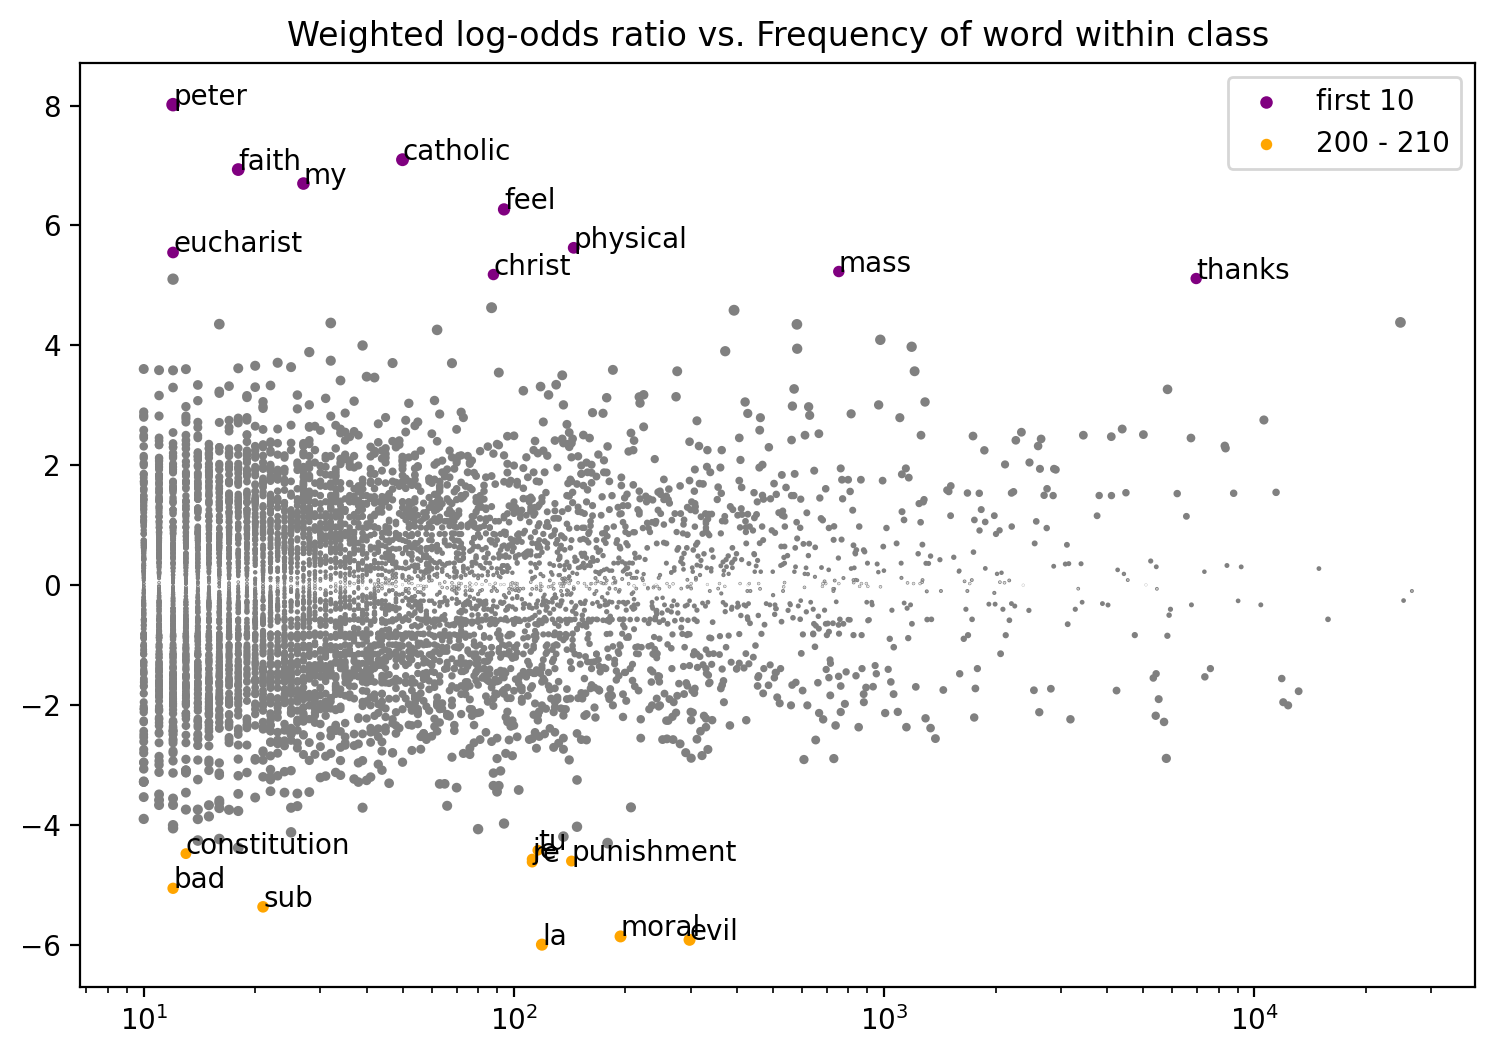

In [447]:
from convokit import Corpus, Speaker, Utterance, FightingWords
fw_dfs = dict()
for subreddit in SUBREDDITS:
    print(subreddit)
    df = comments[subreddit]
    speaker_total_comments = df.groupby("speaker")['order'].max().reset_index(name="n_comments")
    senior_speakers = speaker_total_comments[speaker_total_comments['n_comments'] >= 210]['speaker'].values
    corpus_speakers = {k: Speaker(id = k, meta = {}) for k in senior_speakers}
    utterances = df[df['speaker'].isin(senior_speakers)].reset_index()
    utterance_corpus = {}

    for index, utterance in utterances.iterrows():
        utterance_corpus[index] = Utterance(id = utterance['id'], 
                                            speaker = corpus_speakers[utterance["speaker"]], 
                                            text = str(utterance["text"]), 
                                            meta = {"order": utterance['order']})
    corpus = Corpus(utterances = utterance_corpus.values())
    

    fw = FightingWords(ngram_range=(1,1))
    fw.fit(corpus, class1_func=lambda utt: utt.meta['order'] <= 10, 
                   class2_func=lambda utt: (utt.meta['order'] > 200) and (utt.meta['order'] <= 210))
    
    fw_dfs[subreddit] = fw.summarize(corpus, plot = True, class1_name='first 10', class2_name='200 - 210')

In [534]:
fw_dfs['Christianity'].sort_values("z-score")

,z-score,class
ngram,,
no,-9.738777,200 - 210
you,-8.497551,200 - 210
gender,-7.850525,200 - 210
government,-7.599154,200 - 210
re,-7.120455,200 - 210
...,...,...
jesus,8.876598,first 10
christian,9.477378,first 10
bible,11.502870,first 10


In [537]:
for subreddit in fw_dfs.keys():
    print(subreddit)

    print("first 10: ", ', '.join(list(fw_dfs[subreddit].sort_values("z-score")[::-1][:10].index)))
    print("200th - 210th: ", ', '.join(list(fw_dfs[subreddit].sort_values("z-score")[:10].index)))

#     ', '.join(list(fw_dfs['Buddhism'].sort_values("z-score")[::-1][:10].index))
    

Buddhism
first 10:  suffering, emptiness, memory, vegetarian, thank, nirvana, meditating, meat, wikipedia, attachment
200th - 210th: , url, dhamma, jhana, people, involved, pali, kamma, they, suttas, cult
Christianity
first 10:  god, faith, bible, christian, jesus, my, he, life, his, love
200th - 210th: , no, you, gender, government, re, trump, speech, they, yeah, pornography
TrueChristian
first 10:  my, sabbath, music, me, love, god, am, thank, year, holy
200th - 210th: , we, temple, churches, pornography, if, canon, dating, men, not, view
Judaism
first 10:  rabbi, god, smicha, reform, more, synagogue, kabbalah, kosher, family, feel
200th - 210th: , url, they, marriage, gay, sex, shall, he, eruv, rights, nsfw
exchristian
first 10:  my, grew, music, church, was, situation, myself, back, college, now
200th - 210th: , is, url, relationship, relationships, not, charity, them, he, media, are
Catholicism
first 10:  peter, catholic, faith, my, feel, physical, eucharist, mass, christ, thanks


## Other Explorations

### # of comments in first month statistics (percentile)

In [284]:
subreddit = "Catholicism"
st = speaker_comments_stats[subreddit]
for perc in [50, 60, 70, 80, 90]:
    print(np.percentile(st['n_comments_this_month'], perc))

2.0
4.0
5.0
9.0
21.0


Text(0.5, 1.0, '# of comments per month')

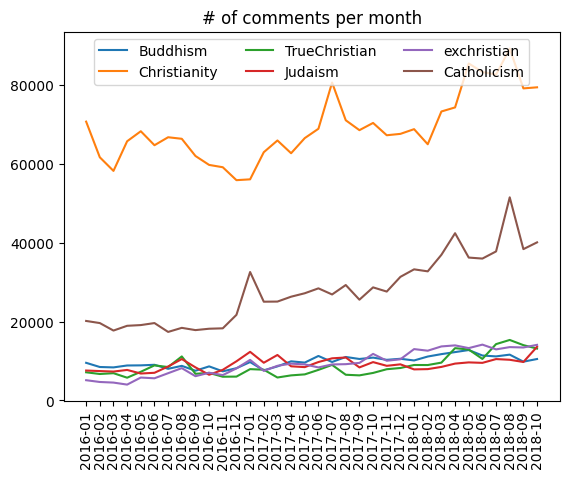

In [558]:
for subreddit in SUBREDDITS:
    df = comments[subreddit]
    df = df[df['meta.year']>=2016]
    plt.plot(df.groupby(['year-month']).size(), label=subreddit)
plt.xticks(rotation=90)
plt.legend(loc='upper center', ncol=3)
plt.title("# of comments per month")
#     print(comments[subreddit].groupby(['year-month']).size().plot())

Text(0.5, 1.0, '# of speakers per month')

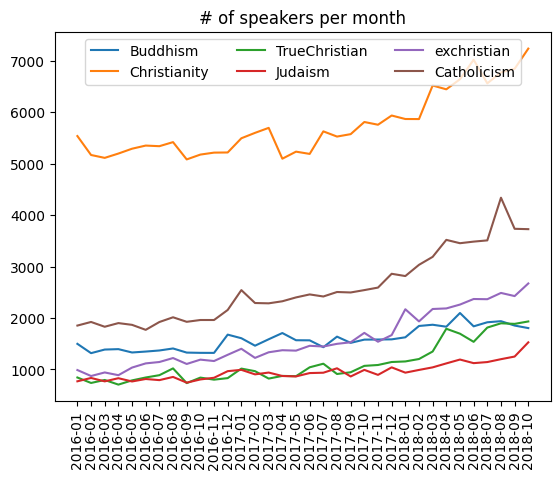

In [557]:
for subreddit in SUBREDDITS:
    df = comments[subreddit]
    df = df[df['meta.year']>=2016]
    plt.plot(df.groupby('year-month')['speaker'].nunique(), label=subreddit)
plt.xticks(rotation=90)
plt.legend(loc='upper center', ncol=3)
plt.title("# of speakers per month")
#     print(comments[subreddit].groupby(['speaker']).size().describe())

In [563]:
newcomer_ratio['Buddhism']['year'] = newcomer_ratio['Buddhism'].index.map(lambda x: int(x.split("-")[0]))

In [564]:
newcomer_ratio['Buddhism']

Buddhism                                                   year
           newcomer utterances speaker oldmembers newcomer / speaker      
year-month                                                                
2008-03           1          1       1          0         100.000000  2008
2008-04           2          3       2          0         100.000000  2008
2008-05           2          7       2          0         100.000000  2008
2008-06           1          2       2          1          50.000000  2008
2008-07           1          3       3          2          33.333333  2008
...             ...        ...     ...        ...                ...   ...
2018-06         659      11945    1935       1276          34.056848  2018
2018-07         737      11657    2017       1280          36.539415  2018
2018-08         705      12138    2030       1325          34.729064  2018
2018-09         665      10300    1938       1273          34.313725  2018
2018-10         676      11001    1902       1226          35.541535  2018

[128 rows x 6 columns]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 [Text(0, 0, '2016-01'),
  Text(1, 0, '2016-02'),
  Text(2, 0, '2016-03'),
  Text(3, 0, '2016-04'),
  Text(4, 0, '2016-05'),
  Text(5, 0, '2016-06'),
  Text(6, 0, '2016-07'),
  Text(7, 0, '2016-08'),
  Text(8, 0, '2016-09'),
  Text(9, 0, '2016-10'),
  Text(10, 0, '2016-11'),
  Text(11, 0, '2016-12'),
  Text(12, 0, '2017-01'),
  Text(13, 0, '2017-02'),
  Text(14, 0, '2017-03'),
  Text(15, 0, '2017-04'),
  Text(16, 0, '2017-05'),
  Text(17, 0, '2017-06'),
  Text(18, 0, '2017-07'),
  Text(19, 0, '2017-08'),
  Text(20, 0, '2017-09'),
  Text(21, 0, '2017-10'),
  Text(22, 0, '2017-11'),
  Text(23, 0, '2017-12'),
  Text(24, 0, '2018-01'),
  Text(25, 0, '2018-02'),
  Text(26, 0, '2018-03'),
  Text(27, 0, '2018-04'),
  Text(28, 0, '2018-05'),
  Text(29, 0, '2018-06'),
  Text(30, 0, '2018-07'),
  Text(31

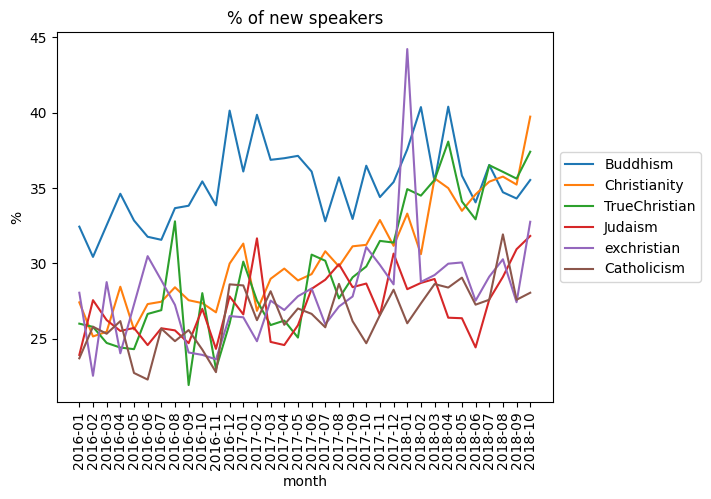

In [573]:
for subreddit in SUBREDDITS:
    s = newcomer_ratio[subreddit]
    s['year'] = s.index.map(lambda x: int(x.split("-")[0]))
    s = s[s['year'] >= 2016]
    plt.plot(s[(subreddit, 'newcomer / speaker')], label=subreddit)
plt.ylabel("%")
plt.xlabel("month")
plt.legend(loc='center left', ncol=1, bbox_to_anchor=(1, 0.5))
plt.title("% of new speakers")
plt.xticks(rotation=90)


## prononuns

In [577]:
import re

In [ ]:
PRONOUNS = ["you/your/yours", "he/him/his", "we/us/our", "I/my/me", "they/their/theirs", "it/its/it's", "she/her/hers"]

In [582]:
def get_pronoun_values(text):
    pronouns = [["you", "your", "yours"], 
                ["he", "him", "his"], 
                ["we", "us", "our"], 
                ["I", "my", "me"], 
                ["they", "their", "theirs"], 
                ["it", "its", "it's"], 
                ["she", "her", "hers"]
               ]

    total_count = 0
    pronoun_dict = {}
    for pronoun_group in pronouns:
        count = 0
        for pronoun in pronoun_group:
            count += len(re.findall(r"\b" + re.escape(pronoun)+ r"\b", text))
            total_count += len(re.findall(r"\b" + re.escape(pronoun)+ r"\b", text))
        pronoun_identifier = "/".join(pronoun_group)
        pronoun_dict[pronoun_identifier] = count
    
    for pronoun_group in pronouns:
        pronoun_identifier = "/".join(pronoun_group)
        if total_count > 0:
            pronoun_dict[pronoun_identifier] = pronoun_dict[pronoun_identifier]/total_count
        else:
            pronoun_dict[pronoun_identifier] = 0
    return pronoun_dict


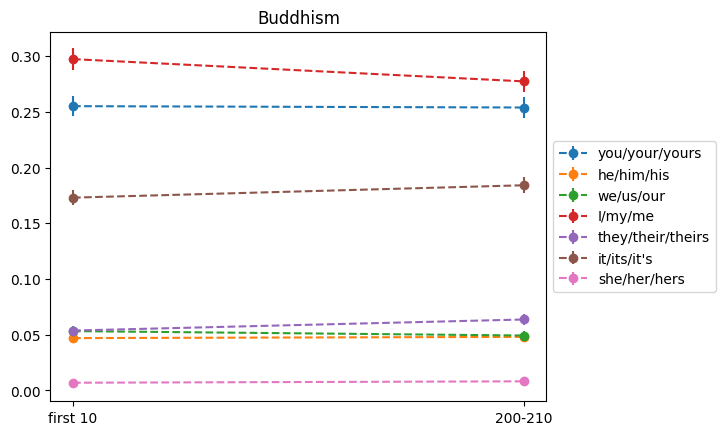

In [647]:
for subreddit in SUBREDDITS:
    df = comments[subreddit]
    df["pronouns"] = df['text'].apply(lambda t: get_pronoun_values(t))
    df = df.reset_index().join(pd.json_normalize(df['pronouns'])).set_index("id")
    
    group = df.sort_values(['speaker', 'timestamp']).groupby(["speaker"])
    df['order'] = group.cumcount() + 1

    speaker_total_comments = df.groupby("speaker")['order'].max().reset_index(name="n_comments")
    speakers = speaker_total_comments[speaker_total_comments['n_comments'] >= 210]['speaker'].values

    # 0 - 10
    early = df[(df['speaker'].isin(speakers)) & (df['order'] <= 10)]

    # 200 - 210
    late = df[(df['speaker'].isin(speakers)) & (df['order'] < 210) & (df['order'] >= 200)]

    for pronoun in PRONOUNS:
        plt.errorbar(
            ['first 10', '200-210'], 
            [
                early[pronoun].mean(),
                late[pronoun].mean()
            ],     
            yerr = [
                calc_conf_interval(early[pronoun].values), 
                calc_conf_interval(late[pronoun].values)
            ],
                fmt="o--",
                label=pronoun)
    plt.title(subreddit)
    plt.legend(loc='center left', ncol=1, bbox_to_anchor=(1, 0.5))